In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import utm

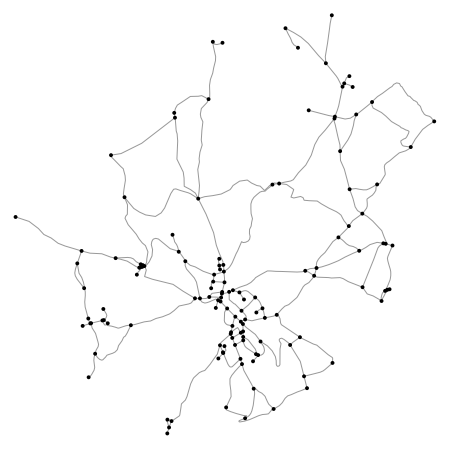

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [2]:
# get network from place name and create undirected graph

city = ox.graph.graph_from_place('Jonzieux',network_type='walk')
city = city.to_undirected()
city_projected = ox.project_graph(city).to_undirected()
ox.plot_graph(city_projected,bgcolor='white',node_color='black')

In [3]:
# eulerize and get circuit

city_eulerized = nx.eulerize(city)
circuit = list(nx.eulerian_circuit(city_eulerized))

In [4]:
# create plots from circuit (for animation)

nodes_projected = ox.graph_to_gdfs(city_projected,edges=False)
west,south,east,north = list(nodes_projected.total_bounds)
p = 500
bbox = north+p,south-p,east+p,west-p

node_container = []

for edge in circuit:
    node_container.extend(edge)
    subgraph = city_projected.subgraph(node_container)
    #fig,ax = ox.plot_graph(subgraph,bgcolor='white',node_color='black',bbox=bbox)

In [5]:
# get coordinates of path and total length

original_nodes,original_edges = ox.graph_to_gdfs(city)
origin = original_nodes[original_nodes.index == circuit[0][0]]
origin = list(origin['geometry'].values[0].coords)

lon_lat_path = origin
total_length = 0

for edge in circuit:
    
    ids = [edge+(0,),edge[::-1]+(0,)]
    gdf_edge = original_edges[original_edges.index.isin(ids)] 
    coords = list(gdf_edge['geometry'].values[0].coords)
    
    if lon_lat_path[-1] == coords[0]:
        lon_lat_path.extend(coords)
        
    else:
        lon_lat_path.extend(coords[::-1])
     
    total_length += gdf_edge['length'].values[0]
    
x,y = [],[]

for point in lon_lat_path:
    x_value,y_value,zn,zl = utm.from_latlon(*point[::-1])
    x.append(x_value),y.append(y_value)

MovieWriter Pillow unavailable; using Pillow instead.


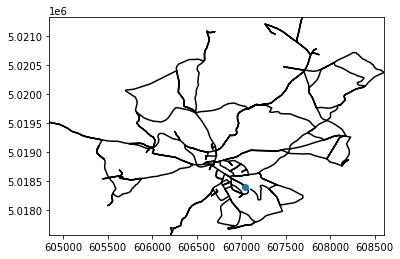

In [6]:
fig, ax = plt.subplots()

line, = ax.plot([],[],color='black')
point, = ax.plot([],[],ls="none",marker="o")
ax.set_xlim([min(x),max(x)])
ax.set_ylim([min(y),max(y)])

def animate(k):
    i = min(k,len(x))
    line.set_data(x[:i],y[:i])
    point.set_data(x[i],y[i])
    return line,point

animation = FuncAnimation(fig=fig, func=animate, frames=range(len(x)),interval=50, blit=True)
animation.save(filename="./animation.gif",writer='Pillow',dpi=80,fps=20)